In [24]:
from pathlib import Path
import json
import math
import re

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import pandas as pd

MUTED_COLORS = [
    "#e41a1c",  # red
    "#377eb8",  # blue
    "#4daf4a",  # green
    "#984ea3",  # purple
    "#ff7f00",  # orange
    "#f781bf",  # pink
    "#a65628",  # brown
    "#999999",  # gray
    "#66c2a5",  # teal
    "#fc8d62",  # salmon
    "#8da0cb",  # periwinkle
    "#e78ac3",  # magenta
]

def extract_model_suffix(model_name: str) -> str:
    """Extract the suffix from model name (e.g., 'clean', 'noisy20', 'noisy40', 'noisy48')."""
    # Pattern to match suffixes like clean, noisy20, noisy40, noisy48
    patterns = [
        r"noisy(\d+)",  # matches noisy20, noisy40, noisy48
        r"clean",        # matches clean
    ]

    for pattern in patterns:
        match = re.search(pattern, model_name, re.IGNORECASE)
        if match:
            if "noisy" in pattern:
                return f"noisy{match.group(1)}"
            return "clean"

    return "unknown"

def plot_many(
    trainer_state_paths,
    checkpoint_num=None,
    smoothing=None,
    fields_to_plot=None,
    legend_labels=None,
    title=None,
    x_title=None,
    y_title=None,
    y_lim=None,
    y_lims=None,
    subplot_titles=None,
):
    """
    Plot training metrics from trainer state files.

    Args:
        trainer_state_paths: Path(s) to trainer state files or directory containing models
        checkpoint_num: Specific checkpoint number to use (None = use latest)
        smoothing: If set (>1), apply spline smoothing with ~3x samples (or at least `smoothing` samples)
        fields_to_plot: List of field names to plot (None = plot all numeric fields)
        legend_labels: Optional labels for each trainer_state path (same length as paths)
        title: Optional overall figure title
        x_title: Optional x-axis label for all subplots
        y_title: Optional y-axis label for all subplots
        y_lim: Optional global (min, max) tuple for fixing y-axis limits
        y_lims: Optional per-subplot limits; list/tuple matching plots or dict keyed by field
        subplot_titles: Optional list of titles per subplot (same length as fields_to_plot/value_cols)
    """
    if not isinstance(trainer_state_paths, (list, tuple)):
        base_path = Path(trainer_state_paths)
        if base_path.is_dir():
            trainer_state_paths = []
            for model_dir in base_path.iterdir():
                if not model_dir.is_dir():
                    continue

                checkpoints = [
                    d
                    for d in model_dir.iterdir()
                    if d.is_dir() and d.name.startswith("checkpoint-")
                ]
                if not checkpoints:
                    continue

                checkpoint_numbers = []
                for cp in checkpoints:
                    try:
                        num = int(cp.name.split("-")[1])
                        checkpoint_numbers.append((num, cp))
                    except (ValueError, IndexError):
                        continue

                if not checkpoint_numbers:
                    continue

                if checkpoint_num is not None:
                    target_checkpoint = None
                    for num, cp in checkpoint_numbers:
                        if num == checkpoint_num:
                            target_checkpoint = cp
                            break
                    if target_checkpoint is None:
                        continue
                else:
                    target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]

                trainer_state_file = target_checkpoint / "trainer_state.json"
                if trainer_state_file.exists():
                    trainer_state_paths.append(trainer_state_file)
        else:
            trainer_state_paths = [base_path]

    if not trainer_state_paths:
        raise ValueError("No trainer state files found")
    
    all_log_dfs = []
    path_labels = []
    
    for trainer_state_path in trainer_state_paths:
        with trainer_state_path.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            raise ValueError(f"log_history is empty in {trainer_state_path}")
        
        log_df = pd.DataFrame(log_history)
        all_log_dfs.append(log_df)
        path_labels.append(trainer_state_path.parent.parent.name)
    
    if not all_log_dfs:
        raise ValueError("No valid trainer states found")
    
    display(all_log_dfs[0].head())

    if legend_labels is not None and len(legend_labels) != len(path_labels):
        print(f"Warning: legend_labels has length {len(legend_labels)} but {len(path_labels)} paths were provided; ignoring custom labels.")
        legend_labels = None
    legend_labels = legend_labels or path_labels
    
    value_cols = [
        col for col in all_log_dfs[0].columns
        if pd.api.types.is_numeric_dtype(all_log_dfs[0][col]) and col != "step"
    ]
    
    # Filter to only requested fields if specified
    if fields_to_plot is not None:
        available_fields = [col for col in fields_to_plot if col in value_cols]
        missing_fields = [col for col in fields_to_plot if col not in value_cols]
        if missing_fields:
            print(f"Warning: Fields not found: {missing_fields}")
        if not available_fields:
            raise ValueError(f"None of the requested fields {fields_to_plot} were found in the data")
        value_cols = available_fields
    
    if subplot_titles is not None and len(subplot_titles) != len(value_cols):
        print(f"Warning: subplot_titles has length {len(subplot_titles)} but {len(value_cols)} subplots will be drawn; ignoring custom subplot titles.")
        subplot_titles = None
    
    num_plots = len(value_cols)
    n_cols = 2
    n_rows = math.ceil(num_plots / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3.25 * n_rows), squeeze=False)
    
    for idx, (ax, col) in enumerate(zip(axes.flat, value_cols)):
        for line_idx, (log_df, label) in enumerate(zip(all_log_dfs, legend_labels)):
            color = MUTED_COLORS[line_idx % len(MUTED_COLORS)]
            x_values = log_df["step"] if "step" in log_df.columns else range(len(log_df))
            if col in log_df.columns:
                y_values = log_df[col]
                x_arr = np.asarray(x_values)
                y_arr = y_values.to_numpy()
                if smoothing is not None and smoothing > 1:
                    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
                    x_clean = x_arr[mask]
                    y_clean = y_arr[mask]
                else:
                    x_clean = x_arr
                    y_clean = y_arr
                if smoothing is not None and smoothing > 1 and len(x_clean) >= 4:
                    try:
                        sort_idx = np.argsort(x_clean)
                        x_sorted = x_clean[sort_idx]
                        y_sorted = y_clean[sort_idx]
                        unique_x, uniq_idx = np.unique(x_sorted, return_index=True)
                        x_sorted = unique_x
                        y_sorted = y_sorted[uniq_idx]
                        if len(x_sorted) >= 4:
                            num_points = max(len(x_sorted) * 3, int(smoothing))
                            x_dense = np.linspace(x_sorted.min(), x_sorted.max(), num=num_points)
                            k = min(3, len(x_sorted) - 1)
                            spline = make_interp_spline(x_sorted, y_sorted, k=k)
                            y_dense = spline(x_dense)
                            ax.plot(x_dense, y_dense, linewidth=1.5, label=label, color=color)
                        else:
                            ax.plot(x_sorted, y_sorted, linewidth=1.5, label=label, color=color)
                    except Exception as exc:
                        print(f"Warning: spline smoothing failed for {label}/{col}: {exc}; plotting raw values.")
                        ax.plot(x_clean, y_clean, linewidth=1.5, label=label, color=color)
                else:
                    ax.plot(x_clean, y_clean, linewidth=1.5, label=label, color=color)
        
        ax.set_title(subplot_titles[idx] if subplot_titles else col)
        ax.set_xlabel(x_title or ("step" if "step" in all_log_dfs[0].columns else "index"))
        ax.set_ylabel(y_title or col)
        ylim = None
        if isinstance(y_lims, dict) and col in y_lims:
            ylim = y_lims[col]
        elif isinstance(y_lims, (list, tuple)) and len(y_lims) == len(value_cols):
            ylim = y_lims[idx]
        elif y_lim is not None:
            ylim = y_lim
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    for ax in axes.flat[num_plots:]:
        ax.axis("off")
    
    if title:
        fig.suptitle(title)
        plt.tight_layout(rect=(0, 0, 1, 0.96))
    else:
        plt.tight_layout()
    plt.show()

def group_models_by_suffix(base_path: Path, checkpoint_num=None):
    """Group model directories by their suffix (clean, noisy20, noisy40, noisy48)."""
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    groups = {}
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        suffix = extract_model_suffix(model_dir.name)
        if suffix not in groups:
            groups[suffix] = []
        groups[suffix].append(trainer_state_file)
    
    return groups


def collect_trainer_state_paths(base_path, models=None, paths=None, checkpoint_num=None):
    """
    Build a list of trainer_state.json files from model directory names and/or explicit paths.

    Args:
        base_path: Root folder containing model directories.
        models: Iterable of model directory names relative to base_path.
        paths: Iterable of explicit paths to model dirs, checkpoint dirs, or trainer_state.json files.
        checkpoint_num: Specific checkpoint to use; default picks the latest.
    """
    base_path = Path(base_path)
    models = models or []
    paths = paths or []
    trainer_state_paths = []
    
    def _checkpoint_dir(model_dir: Path):
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            return None
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        if not checkpoint_numbers:
            return None
        if checkpoint_num is not None:
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    return cp
            return None
        return max(checkpoint_numbers, key=lambda x: x[0])[1]
    
    def _add_trainer_state(model_dir: Path):
        target_cp = _checkpoint_dir(model_dir)
        if target_cp is None:
            print(f"Skipping {model_dir}: no matching checkpoints")
            return
        ts_file = target_cp / "trainer_state.json"
        if ts_file.exists():
            trainer_state_paths.append(ts_file)
        else:
            print(f"Skipping {model_dir}: missing trainer_state.json in {target_cp}")
    
    for model_name in models:
        model_dir = base_path / model_name
        if model_dir.is_dir():
            _add_trainer_state(model_dir)
        else:
            print(f"Skipping missing model dir: {model_dir}")
    
    for p in paths:
        candidate = Path(p)
        if candidate.is_file():
            if candidate.name == "trainer_state.json":
                trainer_state_paths.append(candidate)
            else:
                print(f"Skipping unsupported file: {candidate}")
            continue
        if candidate.is_dir():
            if candidate.name.startswith("checkpoint-"):
                ts_file = candidate / "trainer_state.json"
                if ts_file.exists():
                    trainer_state_paths.append(ts_file)
                else:
                    print(f"Skipping {candidate}: missing trainer_state.json")
            else:
                _add_trainer_state(candidate)
        else:
            print(f"Skipping missing path: {candidate}")
    
    if not trainer_state_paths:
        raise ValueError("No trainer_state.json files found for provided selection")
    
    return trainer_state_paths


def plot_selected(
    base_path,
    models=None,
    paths=None,
    checkpoint_num=None,
    smoothing=None,
    fields_to_plot=None,
    legend_labels=None,
    title=None,
    x_title=None,
    y_title=None,
    y_lim=None,
    y_lims=None,
    subplot_titles=None,
):
    """Convenience wrapper to plot a specific set of models or trainer_state files."""
    trainer_state_paths = collect_trainer_state_paths(
        base_path=base_path,
        models=models,
        paths=paths,
        checkpoint_num=checkpoint_num,
    )
    return plot_many(
        trainer_state_paths,
        checkpoint_num=checkpoint_num,
        smoothing=smoothing,
        fields_to_plot=fields_to_plot,
        legend_labels=legend_labels,
        title=title,
        x_title=x_title,
        y_title=y_title,
        y_lim=y_lim,
        y_lims=y_lims,
        subplot_titles=subplot_titles,
    )

In [25]:
# values
from pathlib import Path
import json
import pandas as pd

def output_metrics(base_path, checkpoint_num=None, metrics_to_show=None):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    results = []
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        with trainer_state_file.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            continue
        
        log_df = pd.DataFrame(log_history)
        
        model_name = model_dir.name
        checkpoint_used = target_checkpoint.name
        
        # If filtering to specific metrics, find the last entry that has those metrics
        if metrics_to_show is not None:
            # Find entries that have at least one of the requested metrics
            available_cols = set(log_df.columns)
            requested_cols = set(metrics_to_show)
            missing_cols = requested_cols - available_cols
            if missing_cols:
                print(f"Warning: {model_name} - missing columns: {missing_cols}")
            
            # Find the last entry that has any of the requested metrics (non-NaN)
            last_entry = None
            if "step" in log_df.columns:
                # Sort by step descending and find first entry with requested metrics
                sorted_df = log_df.sort_values("step", ascending=False)
                for idx, row in sorted_df.iterrows():
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            else:
                # Check from the end backwards
                for idx in range(len(log_df) - 1, -1, -1):
                    row = log_df.iloc[idx]
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            
            if last_entry is None:
                # Fallback to last entry even if NaN
                if "step" in log_df.columns:
                    last_entry = log_df.loc[log_df["step"].idxmax()]
                else:
                    last_entry = log_df.iloc[-1]
        else:
            # Show all metrics - use last entry
            if "step" in log_df.columns:
                last_entry = log_df.loc[log_df["step"].idxmax()]
            else:
                last_entry = log_df.iloc[-1]
        
        metrics = {}
        for col in log_df.columns:
            if pd.api.types.is_numeric_dtype(log_df[col]) and col != "step":
                if metrics_to_show is None or col in metrics_to_show:
                    metrics[col] = last_entry[col]
        
        results.append({
            "model": model_name,
            **metrics
        })
    
    if not results:
        print("No results found")
        return
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("model")
    
    return results_df

display(output_metrics(Path("models_final/"), metrics_to_show=["eval_accuracy", "eval_margin"]))


,model,eval_accuracy,eval_margin
26,Qwen3-0.6B-Base-clean-BT,0.752344,1.085453
22,Qwen3-0.6B-Base-clean-GCE03,0.745898,1.517395
0,Qwen3-0.6B-Base-clean-GCE05,0.750391,2.059500
19,Qwen3-0.6B-Base-clean-GCE07,0.754492,3.346831
25,Qwen3-0.6B-Base-clean-GCE09,0.684180,6.252706
15,Qwen3-0.6B-Base-clean-GCE10,0.734766,12.502379
28,Qwen3-0.6B-Base-clean-SCE-01-10,0.748438,3.571979
30,Qwen3-0.6B-Base-clean-SCE-05-10,0.759180,2.214947
1,Qwen3-0.6B-Base-clean-SCE-07-07,0.749023,1.774218
3,Qwen3-0.6B-Base-clean-SCE-15-05,0.746484,1.402218


Results

In [26]:
# Manual grouping of final checkpoints by noise level
final_base_path = Path("/proj/inf-scaling/iris/dl-rm-loss/reward_modeling/models_final")
final_groups = {
    "clean": [
        final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE05/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-01-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-05-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-07-07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-15-05/checkpoint-969",
    ],
    "noisy20": [
        final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE05/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-01-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-05-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-07-07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-15-05/checkpoint-969",
    ],
    "noisy40": [
        final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE05/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-01-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-05-10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-07-07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-15-05/checkpoint-969",
    ]
}

In [27]:
# Group by loss type (bt/gce/sce) and noise level (clean, noisy20, noisy40)
final_groups_by_loss_and_noise = {
    "bt": {
        "clean": [final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969"],
        "noisy20": [final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969"],
        "noisy40": [final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969"],
    },
    "gce": {
        "clean": [
            final_base_path / "Qwen3-0.6B-Base-clean-GCE03/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE05/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE09/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE10/checkpoint-969",
        ],
        "noisy20": [
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE03/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE05/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE09/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE10/checkpoint-969",
        ],
        "noisy40": [
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE03/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE05/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE10/checkpoint-969",
        ],
    },
    "sce": {
        "clean": [
            final_base_path / "Qwen3-0.6B-Base-clean-SCE-01-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-SCE-05-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-SCE-07-07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-SCE-15-05/checkpoint-969",
        ],
        "noisy20": [
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-01-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-05-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-07-07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-15-05/checkpoint-969",
        ],
        "noisy40": [
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-01-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-05-10/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-07-07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-15-05/checkpoint-969",
        ],
    },
}

In [28]:
best_groups = {
    "clean": [
        final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-05-10/checkpoint-969",
    ],
    "noisy20": [
        final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-07-07/checkpoint-969",
    ],
    "noisy40": [
        final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-05-10/checkpoint-969",
    ],
}

In [29]:
# Legend labels matching the path ordering above
final_group_legend_labels = {
    "clean": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0",
    "SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
    "noisy20": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0",
    "SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
    "noisy40": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0",
    "SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
    "noisy48": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0",
    "SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
}

# Legend labels for final_groups_by_loss_and_noise (same ordering inside each list)
final_groups_by_loss_and_noise_legend_labels = {
    "bt": {
        "clean": ["BT"],
        "noisy20": ["BT"],
        "noisy40": ["BT"],
    },
    "gce": {
        "clean": ["GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0"],
        "noisy20": ["GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0"],
        "noisy40": ["GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0"],
    },
    "sce": {
        "clean": ["SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
        "noisy20": ["SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
        "noisy40": ["SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)", "SCE-(1.5, 0.5)"],
    },
}

best_groups_legend_labels = {
    "clean": ["BT", "GCE-0.7", "SCE-(0.5, 1.0)"],
    "noisy20": ["BT", "GCE-0.3", "SCE-(0.7, 0.7)"],
    "noisy40": ["BT", "GCE-0.9", "SCE-(0.5, 1.0)"],
    "noisy48": ["BT", "GCE-0.7", "SCE-(0.5, 1.0)"],
}

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.579688,0.01032,10.173501,0.000010,0.6767,0.165539,0.608692,-1.209227,-3.214442,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.643750,0.02064,5.643358,0.000010,0.6374,0.372801,2.515709,-0.178398,-2.706198,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.659375,0.03096,7.423118,0.000010,0.6101,0.352643,2.669056,0.569158,-1.299866,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.690625,0.04128,5.862025,0.000010,0.5836,0.666360,4.880084,1.516844,-1.448570,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.670312,0.05160,5.556743,0.000009,0.5877,0.471907,4.830764,2.196658,-0.600705,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


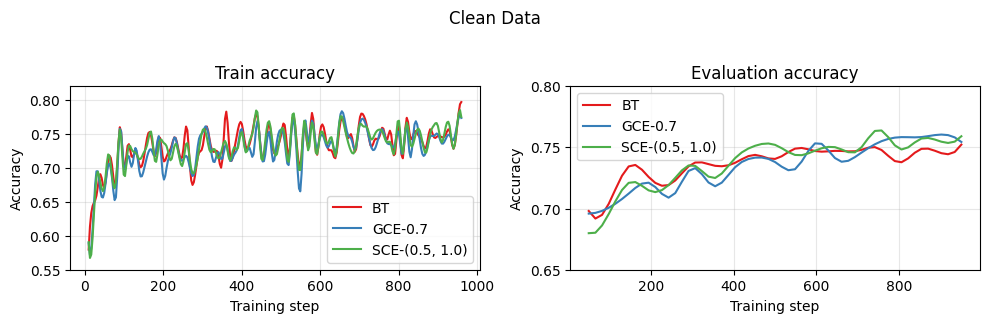

In [50]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["clean"],
    legend_labels=best_groups_legend_labels["clean"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="Clean Data",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
    y_lims=[(0.55, 0.82), (0.65, 0.8)]
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.567187,0.01032,6.046137,0.000010,0.7324,0.034398,-1.528845,-4.103421,-5.687634,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,3.997468,0.000010,0.6921,0.147453,-1.056627,-2.786627,-4.775573,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.593750,0.03096,3.373561,0.000010,0.6711,0.077883,-0.377421,-1.226827,-2.198720,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.578125,0.04128,3.109027,0.000010,0.6824,0.150327,0.888392,-0.625503,-2.152691,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.589063,0.05160,3.335930,0.000009,0.6662,0.130977,1.988289,0.249928,-1.035264,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


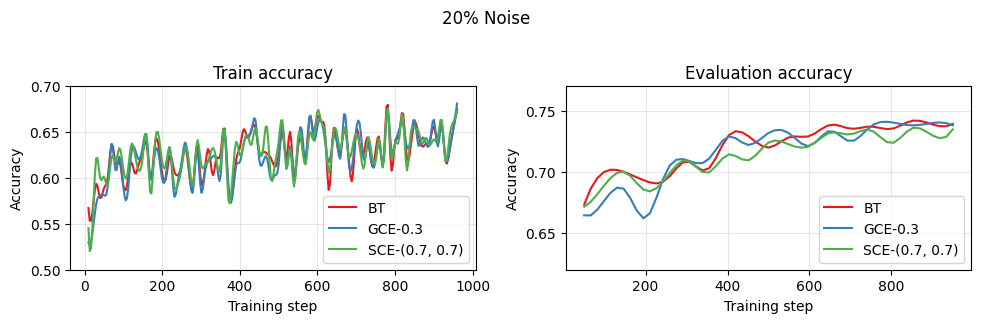

In [52]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["noisy20"],
    legend_labels=best_groups_legend_labels["noisy20"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="20% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
    y_lims=[(0.5, 0.7), (0.62, 0.77)]
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.492188,0.01032,5.213758,0.000010,0.7259,0.002485,5.326846,3.565464,1.687398,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.521875,0.02064,2.177735,0.000010,0.7064,-0.007228,4.235545,3.233110,2.101016,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.496875,0.03096,2.361068,0.000010,0.6935,0.010059,2.813201,1.854601,0.995472,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.492188,0.04128,1.410109,0.000010,0.6979,-0.002217,2.747095,1.861573,1.238248,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.520312,0.05160,1.405182,0.000009,0.6909,0.009434,1.626536,1.132094,0.530329,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


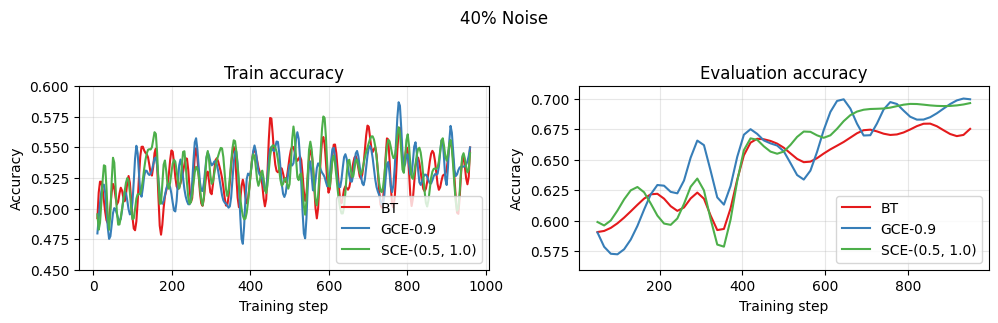

In [53]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["noisy40"],
    legend_labels=best_groups_legend_labels["noisy40"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="40% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
    y_lims=[(0.45, 0.6), (0.56, 0.71)]
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.450000,0.01032,28.320515,0.000010,1.6515,-0.075754,4.593525,2.146875,-0.837557,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.478125,0.02064,13.507640,0.000010,1.6274,-0.036787,2.768662,-0.063615,-3.109408,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.540625,0.03096,15.326875,0.000010,1.5479,0.092678,3.466862,-0.053549,-3.560256,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.482812,0.04128,40.889675,0.000010,1.6187,-0.022432,5.105252,2.913421,-0.689051,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.512500,0.05160,13.883552,0.000009,1.5691,0.071000,5.333130,2.106236,-2.195623,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


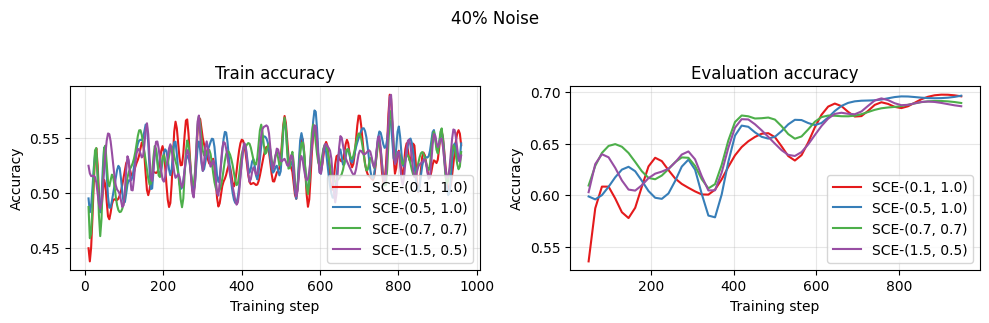

In [33]:
plot_selected(
    base_path="models_final/",
    paths=final_groups_by_loss_and_noise["sce"]["noisy40"],
    legend_labels=final_groups_by_loss_and_noise_legend_labels["sce"]["noisy40"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="40% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)